In [1]:
import numpy as np
import time
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.stats import qmc

In [2]:
tf.keras.backend.set_floatx("float64")

In [3]:
### data generation
n_bc = 4
n_data_per_bc = 25
#
engine = qmc.LatinHypercube(d=1)
data = np.zeros([4, 25, 4])

In [4]:
def generate_boundary_condition(n_bc, n_data_per_bc, total_columns, time_range_shifter):
    data = np.zeros([n_bc, n_data_per_bc, total_columns])
    engine = qmc.LatinHypercube(d=1)
    for i, j in zip(range(n_bc), [-1, +1, -1, +1]):
        points = (engine.random(n=n_data_per_bc)[:, 0] - 0.5) * 2
        #random_time = np.random.random(25) + time_range_shifter  
        if i < 2:
            data[i, :, 0] = j
            data[i, :, 1] = points
            data[i, :, 2] = time_range_shifter
        else:
            data[i, :, 0] = points
            data[i, :, 1] = j
            data[i, :, 2] = time_range_shifter

    data[0, :, 3] = 300/400
    data[1, :, 3] = 300/400
    data[2, :, 3] = 1
    data[3, :, 3] = 273/400
    return data

In [5]:
data_0 = generate_boundary_condition(n_bc, n_data_per_bc,4, 0)
data_1 = generate_boundary_condition(n_bc, n_data_per_bc,4, 1)
data_2 = generate_boundary_condition(n_bc, n_data_per_bc,4, 2)
data_3 = generate_boundary_condition(n_bc, n_data_per_bc,4, 3)
data_4 = generate_boundary_condition(n_bc, n_data_per_bc,4, 4)
data_5 = generate_boundary_condition(n_bc, n_data_per_bc,4, 5)
data_6 = generate_boundary_condition(n_bc, n_data_per_bc,4, 6)
data_7 = generate_boundary_condition(n_bc, n_data_per_bc,4, 7)
data_8 = generate_boundary_condition(n_bc, n_data_per_bc,4, 8)
data_9 = generate_boundary_condition(n_bc, n_data_per_bc,4, 9)
data_10 = generate_boundary_condition(n_bc, n_data_per_bc,4, 10)


In [6]:
data_0 = data_0.reshape(n_data_per_bc * n_bc, 4)
data_1 = data_1.reshape(n_data_per_bc * n_bc, 4)
data_2 = data_2.reshape(n_data_per_bc * n_bc, 4)
data_3 = data_3.reshape(n_data_per_bc * n_bc, 4)
data_4 = data_4.reshape(n_data_per_bc * n_bc, 4)
data_5 = data_5.reshape(n_data_per_bc * n_bc, 4)
data_6 = data_6.reshape(n_data_per_bc * n_bc, 4)
data_7 = data_7.reshape(n_data_per_bc * n_bc, 4)
data_8 = data_8.reshape(n_data_per_bc * n_bc, 4)
data_9 = data_9.reshape(n_data_per_bc * n_bc, 4)
data_10 = data_10.reshape(n_data_per_bc * n_bc, 4)


In [7]:
data = np.concatenate([data_0,data_1,data_2,data_3,data_4,data_5,data_6,data_7,data_8,data_9,data_10])

In [8]:
x_d, y_d, t_d, T_d = map(lambda x: np.expand_dims(x, axis=1), [data[:, 0], data[:, 1], data[:, 2], data[:, 3]])

In [9]:
Nc = 10000
engine = qmc.LatinHypercube(d=2)
colloc = engine.random(n=Nc)
colloc = 2 * (colloc -0.5)
#
x_c, y_c = map(lambda x: np.expand_dims(x, axis=1), [colloc[:, 0], colloc[:, 1]])



In [10]:
tc_i = np.ones_like(x_c) 

In [11]:
t_c_full = np.concatenate([tc_i*0,tc_i*1,tc_i*2,tc_i*3,tc_i*4,tc_i*5,tc_i*6,tc_i*7,tc_i*8,tc_i*9,tc_i*10])

In [12]:
x_c_full = np.concatenate([x_c,x_c,x_c,x_c,x_c,x_c,x_c,x_c,x_c,x_c,x_c])
y_c_full = np.concatenate([y_c,y_c,y_c,y_c,y_c,y_c,y_c,y_c,y_c,y_c,y_c])

In [13]:
time_0 = np.zeros_like(x_c)
value_time_o = np.ones_like(x_c) * (300/400)

In [14]:
### model builder function
def DNN_builder(in_shape=3, out_shape=1, n_hidden_layers=10, 
                neuron_per_layer=20, actfn="tanh"):
    # input layer
    input_layer = tf.keras.layers.Input(shape=(in_shape,))
    # hidden layers
    hidden = [tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(input_layer)]
    for i in range(n_hidden_layers-1):
        new_layer = tf.keras.layers.Dense(neuron_per_layer,
                                          activation=actfn,
                                          activity_regularizer=None)(hidden[-1])
        hidden.append(new_layer)
    # output layer
    output_layer = tf.keras.layers.Dense(1, activation=None)(hidden[-1])
    # building the model
    name = f"DNN-{n_hidden_layers}"
    model = tf.keras.Model(input_layer, output_layer, name=name)
    return model


In [20]:
tf.keras.backend.clear_session()
model = DNN_builder(3, 1, 9, 20, "tanh")
model.summary()
tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, 
                          show_layer_names=True, show_dtype=True, 
                          show_layer_activations=True)

Model: "DNN-9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3)]               0         
                                                                 
 dense (Dense)               (None, 20)                80        
                                                                 
 dense_1 (Dense)             (None, 20)                420       
                                                                 
 dense_2 (Dense)             (None, 20)                420       
                                                                 
 dense_3 (Dense)             (None, 20)                420       
                                                                 
 dense_4 (Dense)             (None, 20)                420       
                                                                 
 dense_5 (Dense)             (None, 20)                420   

In [25]:
@tf.function
def u(x, y, t):
    u = model(tf.concat([x, y,t], axis=1))
    return u

In [26]:
@tf.function
def f(x, y,t):
    u0 = u(x, y,t)
    u_x = tf.gradients(u0, x)[0]
    u_y = tf.gradients(u0, y)[0]
    u_t = tf.gradients(u0, t)[0]
    u_xx = tf.gradients(u_x, x)[0]
    u_yy = tf.gradients(u_y, y)[0]
    F = u_t - u_xx - u_yy
    return tf.reduce_mean(tf.square(F))

In [27]:
@tf.function
def mse(y, y_):
    return tf.reduce_mean(tf.square(y-y_))

    0, 0.004
  199, 0.003

computation time: 1652.744



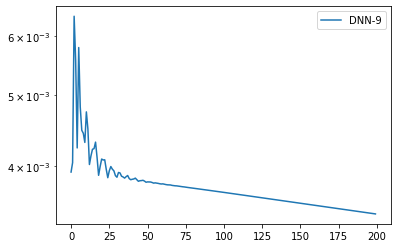

In [30]:
loss = 0
epochs = 200
opt = tf.keras.optimizers.Adam(learning_rate=5e-4)
epoch = 0
loss_values = np.array([])
#
start = time.time()
#
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        T_ = u(x_d, y_d, t_d)
        l = mse(T_d, T_)        
        intial = u(x_c, y_c, time_0 ) 
        intial_loss = mse(value_time_o, intial)
        L = f(x_c_full, y_c_full, t_c_full)
        loss = l +L +intial_loss
    g = tape.gradient(loss, model.trainable_weights)
    opt.apply_gradients(zip(g, model.trainable_weights))
    loss_values = np.append(loss_values, loss)
    if epoch % 200 == 0 or epoch == epochs-1:
        print(f"{epoch:5}, {loss.numpy():.3f}")

#
end = time.time()
computation_time = {}
computation_time["pinn"] = end - start
print(f"\ncomputation time: {end-start:.3f}\n")
#
plt.semilogy(loss_values, label=model.name)
plt.legend()

In [31]:
zaman = np.zeros_like()

In [34]:
n = 100
l = 1.
r = 2*l/(n+1)
T = np.zeros([n*n, n*n])
bc = {
    "x=-l": 300.,
    "x=+l": 300.,
    "y=-l": 374.,
    "y=+l": 400.
}
X = np.linspace(-1, +1, n)
Y = np.linspace(-1, +1, n)
X0, Y0 = np.meshgrid(X, Y)
X = X0.reshape([n*n, 1])
Y = Y0.reshape([n*n, 1])
X_T = tf.convert_to_tensor(X)
Y_T = tf.convert_to_tensor(Y)


In [50]:
zaman = tf.ones_like(X_T) * 0.2 
zaman

<tf.Tensor: shape=(10000, 1), dtype=float64, numpy=
array([[0.2],
       [0.2],
       [0.2],
       ...,
       [0.2],
       [0.2],
       [0.2]])>

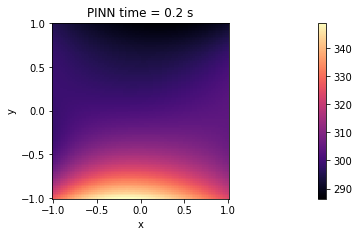

In [52]:
S = u(X_T, Y_T,zaman)
S = S.numpy().reshape(n, n)
plt.figure("", figsize=(12, 6))
plt.subplot(221)
plt.pcolormesh(X0, Y0, 400.*S, cmap="magma")
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y")
plt.title("PINN time = 0.2 s")
plt.tight_layout()
plt.axis("square")
plt.show()
